# Directly Feeding the images to CNN
In this notebook, the kaggle-data is directly fed to a simple convolutional neural-network

In [2]:
import dicom # for reading dicom files
import os # for doing directory operations 
import pandas as pd # for some simple data analysis (right now, just to load in the labels data and quickly reference it)

data_dir = './data/'
patients = os.listdir(data_dir)
labels_df = pd.read_csv('./stage1_labels.csv', index_col=0)

labels_df.head()

,cancer
id,
00edff4f51a893d80dae2d42a7f45ad1,1.0
NaN,NaN
NaN,NaN
NaN,NaN
NaN,NaN


## View the data

00cba091fa4ad62cc3200a657aeb957e
134 0
(512, 512) 134


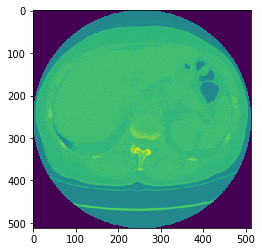

0a099f2549429d29b32f349e95fb2244
128 0
(512, 512) 128


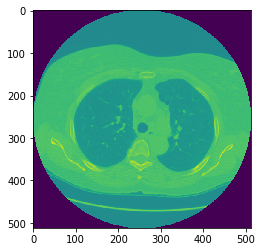

0a0c32c9e08cc2ea76a71649de56be6d
133 0
(512, 512) 133


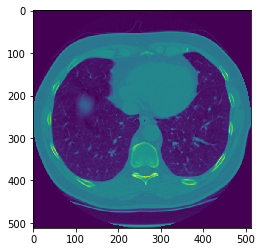

0a38e7597ca26f9374f8ea2770ba870d
110 0
(512, 512) 110


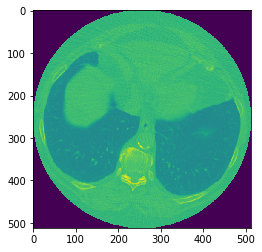

0acbebb8d463b4b9ca88cf38431aac69
203 1
(512, 512) 203


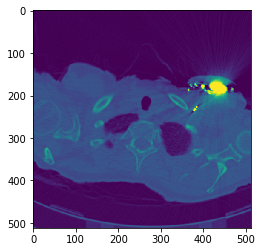

0bd0e3056cbf23a1cb7f0f0b18446068
280 0
(512, 512) 280


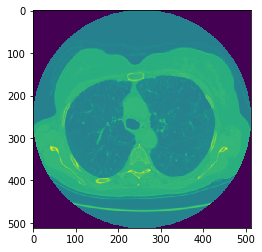

0c0de3749d4fe175b7a5098b060982a1
123 1
(512, 512) 123


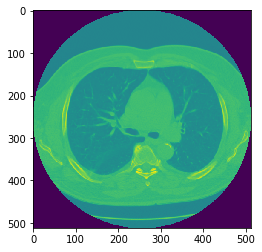

0c37613214faddf8701ca41e6d43f56e
164 1
(512, 512) 164


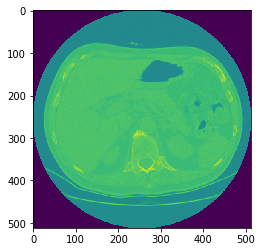

0c59313f52304e25d5a7dcf9877633b1
244 0
(512, 512) 244


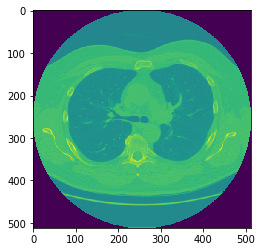

0c60f4b87afcb3e2dfa65abbbf3ef2f9
136 1
(512, 512) 136


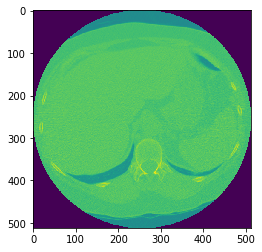

0c98fcb55e3f36d0c2b6507f62f4c5f1
180 0
(512, 512) 180


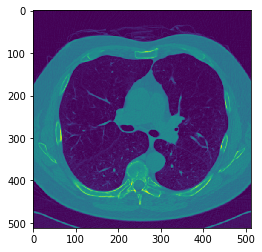

0c9d8314f9c69840e25febabb1229fa4
221 0
(512, 512) 221


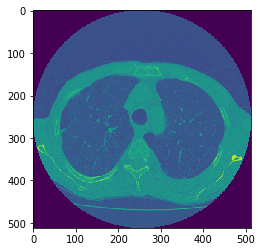

0ca943d821204ceb089510f836a367fd
147 0
(512, 512) 147


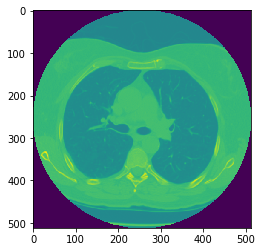

0d06d764d3c07572074d468b4cff954f
435 1
(512, 512) 435


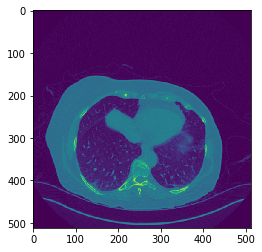

0d19f1c627df49eb223771c28548350e
183 0
(512, 512) 183


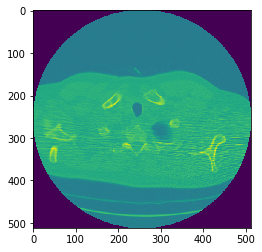

0d2fcf787026fece4e57be167d079383
126 0
(512, 512) 126


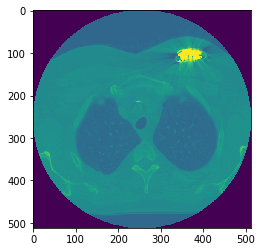

0d941a3ad6c889ac451caf89c46cb92a
177 0
(512, 512) 177


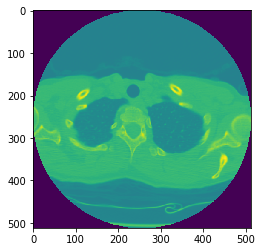

0ddeb08e9c97227853422bd71a2a695e
171 0
(512, 512) 171


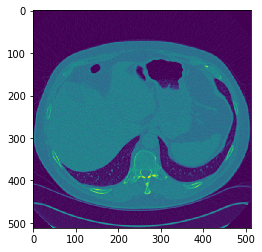

0de72529c30fe642bc60dcb75c87f6bd
113 0
(512, 512) 113


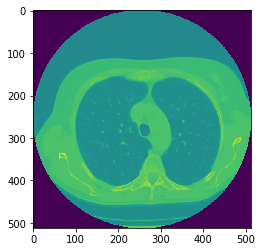

In [69]:
import matplotlib.pyplot as plt
for patient in patients:
    print(patient)
    label = labels_df.get_value(patient, 'cancer')
    
    path = data_dir + patient
    
    slices = [dicom.read_file(path + '/' + s) for s in os.listdir(path)]
    
    print(len(slices),label)
    print(slices[0].pixel_array.shape, len(slices))
    plt.imshow(slices[0].pixel_array)
    plt.savefig('image.png')


In [70]:
# Total 19 patients are there in sample
len(patients)

19

## Function for resizing to 50 x 50 x 20 sized 3-D matrix

In [71]:
def process_data(patient,labels_df,img_px_size=50, hm_slices=20, visualize=False):
    
    label = labels_df.get_value(patient, 'cancer')
    path = data_dir + patient
    slices = [dicom.read_file(path + '/' + s) for s in os.listdir(path)]
    slices.sort(key = lambda x: int(x.ImagePositionPatient[2]))

    new_slices = []
    slices = [cv2.resize(np.array(each_slice.pixel_array),(img_px_size,img_px_size)) for each_slice in slices]
    
    chunk_sizes = math.ceil(len(slices) / hm_slices)
    for slice_chunk in chunks(slices, chunk_sizes):
        slice_chunk = list(map(mean, zip(*slice_chunk)))
        new_slices.append(slice_chunk)

    if len(new_slices) == hm_slices-1:
        new_slices.append(new_slices[-1])

    if len(new_slices) == hm_slices-2:
        new_slices.append(new_slices[-1])
        new_slices.append(new_slices[-1])

    if len(new_slices) == hm_slices+2:
        new_val = list(map(mean, zip(*[new_slices[hm_slices-1],new_slices[hm_slices],])))
        del new_slices[hm_slices]
        new_slices[hm_slices-1] = new_val
        
    if len(new_slices) == hm_slices+1:
        new_val = list(map(mean, zip(*[new_slices[hm_slices-1],new_slices[hm_slices],])))
        del new_slices[hm_slices]
        new_slices[hm_slices-1] = new_val

    if visualize:
        fig = plt.figure()
        for num,each_slice in enumerate(new_slices):
            y = fig.add_subplot(4,5,num+1)
            y.imshow(each_slice, cmap='gray')
        plt.show()

    if label == 1: label=np.array([0,1])
    elif label == 0: label=np.array([1,0])
        
    return np.array(new_slices),label

## The following code, converts all images to 50 x 50 x 20 and saves it as muchdata

In [72]:
much_data = []
labels = pd.read_csv('./stage1_labels.csv', index_col=0)
for num,patient in enumerate(patients):
    if num % 100 == 0:
        print(num)
    try:
        img_data,label = process_data(patient,labels,img_px_size=IMG_SIZE_PX, hm_slices=SLICE_COUNT)
        #print(img_data.shape,label)
        much_data.append([img_data,label])
    except KeyError as e:
        print('This is unlabeled data!')

np.save('muchdata-{}-{}-{}.npy'.format(IMG_SIZE_PX,IMG_SIZE_PX,SLICE_COUNT), much_data)

0


## CNN architecture

In [7]:
import tensorflow as tf
import numpy as np

IMG_SIZE_PX = 50
SLICE_COUNT = 20

n_classes = 2
batch_size = 10

x = tf.placeholder('float')
y = tf.placeholder('float')

keep_rate = 0.8

In [8]:
def conv3d(x, W):
    return tf.nn.conv3d(x, W, strides=[1,1,1,1,1], padding='SAME')

def maxpool3d(x):
    #                        size of window         movement of window as you slide about
    return tf.nn.max_pool3d(x, ksize=[1,2,2,2,1], strides=[1,2,2,2,1], padding='SAME')

In [9]:
def convolutional_neural_network(x):
    #                # 50 x 50 x 20 patches, 1 channel, 32 features to compute.
    weights = {'W_conv1':tf.Variable(tf.random_normal([3,3,3,1,32])),
               #       5 x 5 x 5 patches, 32 channels, 64 features to compute.
               'W_conv2':tf.Variable(tf.random_normal([3,3,3,32,64])),
               #                                  64 features
               'W_fc':tf.Variable(tf.random_normal([54080,1024])),
               'out':tf.Variable(tf.random_normal([1024, n_classes]))}

    biases = {'b_conv1':tf.Variable(tf.random_normal([32])),
               'b_conv2':tf.Variable(tf.random_normal([64])),
               'b_fc':tf.Variable(tf.random_normal([1024])),
               'out':tf.Variable(tf.random_normal([n_classes]))}

    #                            image X      image Y        image Z
    x = tf.reshape(x, shape=[-1, IMG_SIZE_PX, IMG_SIZE_PX, SLICE_COUNT, 1])
    
    conv1 = tf.nn.relu(conv3d(x, weights['W_conv1']) + biases['b_conv1'])
    # https://www.tensorflow.org/versions/r0.12/api_docs/python/nn/convolution
    #Output : 32*50*50*20, 
    conv1 = maxpool3d(conv1)
    # first answer : https://stackoverflow.com/questions/37674306/what-is-the-difference-between-same-and-valid-padding-in-tf-nn-max-pool-of-t
    #Output : 32*25*25*10

    conv2 = tf.nn.relu(conv3d(conv1, weights['W_conv2']) + biases['b_conv2'])
    #Output : 64*25*25*10
    conv2 = maxpool3d(conv2)
    #Output : 64*13*13*10

    fc = tf.reshape(conv2,[-1, 54080])
    fc = tf.nn.relu(tf.matmul(fc, weights['W_fc'])+biases['b_fc'])
    fc = tf.nn.dropout(fc, keep_rate)

    output = tf.matmul(fc, weights['out'])+biases['out']

    return output

## Training the CNN

In [28]:
import numpy as np
import tensorflow as nf
much_data = np.load('muchdata-50-50-20.npy')

# Change below for large data, 2 is for sample validation data only
train_data = much_data[:-2]
validation_data = much_data[-2:]

def train_neural_network(x):
    prediction = convolutional_neural_network(x)
    cost = tf.reduce_mean( tf.nn.softmax_cross_entropy_with_logits(logits = prediction,labels = y) )
    optimizer = tf.train.AdamOptimizer(learning_rate=1e-3).minimize(cost)
    
    hm_epochs = 10
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        
        successful_runs = 0
        total_runs = 0
        
        for epoch in range(hm_epochs):
            epoch_loss = 0
            for batch in train_data:
                
                total_runs += 1
                try:
                    
                    X = batch[0]
                    Y = batch[1]
                    _, c = sess.run([optimizer, cost], feed_dict={x: X, y: Y})
                    epoch_loss += c
                    successful_runs += 1
                except Exception as e:
                    
                    pass
                    
            
            print('Epoch', epoch+1, 'completed out of',hm_epochs,'loss:',epoch_loss)

            correct = tf.equal(tf.argmax(prediction, 1), tf.argmax(y, 1))
            accuracy = tf.reduce_mean(tf.cast(correct, 'float'))

            print('Accuracy:',accuracy.eval({x:[i[0] for i in validation_data], y:[i[1] for i in validation_data]}))
            
        print('Done. Finishing accuracy:')
        print('Accuracy:',accuracy.eval({x:[i[0] for i in validation_data], y:[i[1] for i in validation_data]}))
        
        print('fitment percent:',successful_runs/total_runs)

# Run this locally:
train_neural_network(x)

Epoch 1 completed out of 10 loss: 12260523360.0
Accuracy: 1.0
Epoch 2 completed out of 10 loss: 27335268160.0
Accuracy: 0.5
Epoch 3 completed out of 10 loss: 21524270528.0
Accuracy: 0.0
Epoch 4 completed out of 10 loss: 9843686912.0
Accuracy: 1.0
Epoch 5 completed out of 10 loss: 16091573792.0
Accuracy: 0.0
Epoch 6 completed out of 10 loss: 12192018152.0
Accuracy: 0.5
Epoch 7 completed out of 10 loss: 1114852384.0
Accuracy: 1.0
Epoch 8 completed out of 10 loss: 3903982720.0
Accuracy: 0.5
Epoch 9 completed out of 10 loss: 1838231040.0
Accuracy: 0.0
Epoch 10 completed out of 10 loss: 4128361504.0
Accuracy: 1.0
Done. Finishing accuracy:
Accuracy: 0.5
fitment percent: 1.0


In [ ]:
labels_df.cancer.value_counts()